In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.gofplots import qqplot
from typing import Union
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

In [24]:
df=pd.read_csv('Quarterly_Earnings_per_Johnson___Johnson_Share_398_57(2) (1).csv')
df.head()

,Unnamed: 0,X,date,value
0,1,1,1960-01-01,0.71
1,2,2,1960-04-01,0.63
2,3,3,1960-07-01,0.85
3,4,4,1960-10-01,0.44
4,5,5,1961-01-01,0.61


In [7]:
ADF_result=adfuller(df['value'])
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: 2.742016957040678
p-value: 1.0


In [9]:
eps_diff=np.diff(df['value'],n=1)
ad_fuller_result = adfuller(eps_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -0.4074097640821012
p-value: 0.9088542416161047


In [10]:
eps_diff2=np.diff(eps_diff,n=1)
ad_fuller_result = adfuller(eps_diff2)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.5851630823990197
p-value: 0.006051095719849839


In [13]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [16]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 2
 
order_list = list(product(ps, qs))

In [17]:
train=df['value'][:-4]

result_df=optimize_ARIMA(train,order_list,d)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 3)",115.270458
1,"(3, 1)",115.625002
2,"(3, 2)",115.672030
3,"(3, 0)",154.430644
4,"(0, 3)",194.654718
5,"(0, 2)",209.274489
6,"(2, 3)",220.666937
7,"(1, 3)",228.267748
8,"(1, 2)",228.935801
9,"(2, 2)",229.974665


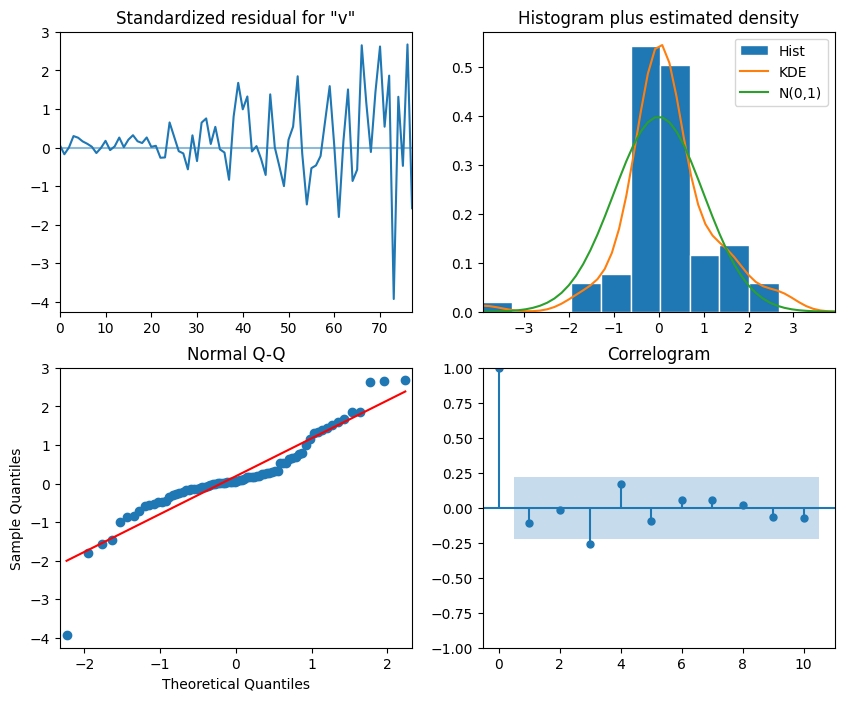

In [18]:
model = SARIMAX(train, order=(3,2,3), simple_differencing=False)
model_fit = model.fit(disp=False)
model_fit.plot_diagnostics(figsize=(10,8));

#top left: It does not have a trend. variation based on noise. Having a posetive or negative trend. There is a correlation
#between the resedual and the variable we try to predict. It does not have any correlation to the variable. 

#top right: almost close to normal distrubution. no correlation between residual and variable. Noise. 

#bottom left: error being based on noise, we can ignore it. 

#bottom right: only one spike, all the little spikes are close to zero. It can also be described as noise. 
#no correlation between the residual and the value we're trying to predict. 

In [19]:
test = df.iloc[-4:]
 
test['naive_seasonal'] = df['value'].iloc[76:80].values
test

,Unnamed: 0,X,date,value,naive_seasonal
80,81,81,1980-01-01,16.20,14.04
81,82,82,1980-04-01,14.67,12.96
82,83,83,1980-07-01,16.02,14.85
83,84,84,1980-10-01,11.61,9.99


In [20]:
ARIMA_pred = model_fit.get_prediction(80, 83).predicted_mean
 
test['ARIMA_pred'] = ARIMA_pred
test

,Unnamed: 0,X,date,value,naive_seasonal,ARIMA_pred
80,81,81,1980-01-01,16.20,14.04,15.853557
81,82,82,1980-04-01,14.67,12.96,14.379773
82,83,83,1980-07-01,16.02,14.85,16.365048
83,84,84,1980-10-01,11.61,9.99,11.683733


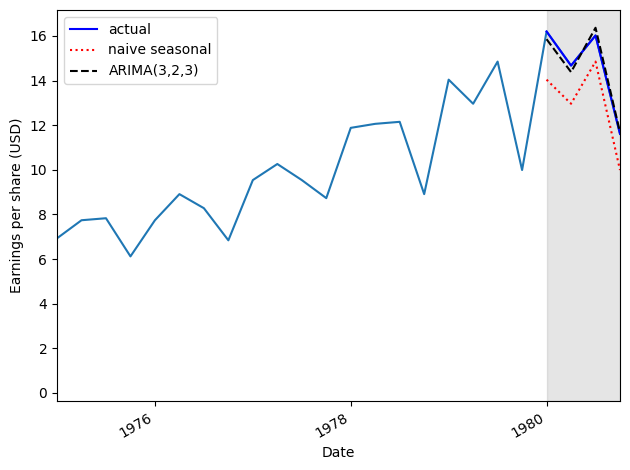

In [21]:
fig, ax = plt.subplots()
 
ax.plot(df['date'], df['value'])
ax.plot(test['value'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(3,2,3)')
 
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)
 
ax.legend(loc=2)
 
plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])
ax.set_xlim(60, 83)
 
fig.autofmt_xdate()
plt.tight_layout()

In [22]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [23]:
mape_naive_seasonal = mape(test['value'], test['naive_seasonal'])
mape_ARIMA = mape(test['value'], test['ARIMA_pred'])
 
print(mape_naive_seasonal, mape_ARIMA)

11.561658552433654 1.7264635960191221
